# Fine-Tuning Pre-trained Models on Custom Data
## Using Transfer Learning with VGG16, ResNet50, and MobileNetV2

**Optimized for Google Colab**

In this notebook, I will :
1. Download images from Pixabay API in your chosen categories
2. Build a dataset of 2-5 image categories
3. Fine-tune three pre-trained models on your custom data
4. Compare performance and training efficiency
5. Make predictions on new images


---

## Part 0: Setup

In [24]:
# Verify we're in Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print(f"Running in Google Colab: {IN_COLAB}")

if IN_COLAB:
    print("✓ Google Colab detected")
else:
    print("⚠ Not in Google Colab. This notebook works best in Colab.")

Running in Google Colab: False
⚠ Not in Google Colab. This notebook works best in Colab.


In [25]:
# Core imports
import os
import json
import requests
from pathlib import Path
import random
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import seaborn as sns
from PIL import Image
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# TensorFlow/Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Configure
K.set_image_data_format('channels_last')
tf.get_logger().setLevel('ERROR')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("✓ All imports successful!")
print(f"TensorFlow version: {tf.__version__}")

✓ All imports successful!
TensorFlow version: 2.20.0


In [26]:
# Check GPU availability
gpu_available = len(tf.config.list_physical_devices('GPU')) > 0
print(f"GPU Available: {gpu_available}")

if not gpu_available and IN_COLAB:
    print("\n⚠️ WARNING: GPU not enabled!")
    print("Go to: Edit → Notebook settings → Hardware accelerator → GPU")
else:
    print("✓ GPU is ready for training")

GPU Available: False
✓ GPU is ready for training


---
## Part 1: Configuration and Pixabay Setup

### Step 1.1: Configure the Dataset

In [27]:
CATEGORIES = ['strawberry', 'banana', 'pineapple']  

# Images per category 
IMAGES_PER_CATEGORY = 150 

# Dataset paths
BASE_DIR = '/content/dataset'
DOWNLOAD_DIR = os.path.join(BASE_DIR, 'downloads')
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Create directories
for directory in [DOWNLOAD_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(directory, exist_ok=True)
    for category in CATEGORIES:
        os.makedirs(os.path.join(directory, category), exist_ok=True)

print(f"Categories: {CATEGORIES}")
print(f"Images per category: {IMAGES_PER_CATEGORY}")
print(f"Total expected images: {len(CATEGORIES) * IMAGES_PER_CATEGORY}")
print(f"\n✓ Directories created at: {BASE_DIR}")

Categories: ['strawberry', 'banana', 'pineapple']
Images per category: 150
Total expected images: 450

✓ Directories created at: /content/dataset


### Step 1.2: Pixabay API Integration

In [ ]:
from config import PIXABAY_API_KEY

def get_pixabay_images(query, num_images=50, per_page=50):
    """
    Download image URLs from Pixabay API.

    Pixabay API is free and doesn't require API key for basic usage.
    For production, get a free API key at: https://pixabay.com/api/docs/
    """
    # Using API with a key (limited to ~100 requests/hour for free tier)
    url = 'https://pixabay.com/api/'
    params = {
      'key' : PIXABAY_API_KEY,
      'q': query,
      'image_type': 'photo',
      'per_page': max(per_page, 200),
      'safesearch': 'true',
      'order': 'popular',
      'category': 'food',
      }

    try :
      response = requests.get(url, params=params, timeout=10)
      response.raise_for_status()
      data=response.json()

      if 'hits' in data:
        image_urls = []
        for hit in data['hits'][:num_images]:
          image_urls.append(hit['largeImageURL'])
        return image_urls
      else:
        print(f"No 'hits' key found in the response for query: '{query}'")
        return []

    except Exception as e:
      print(f"error fetching images for '{query}':{e}")
      return []

def download_image(url, filepath, timeout=5):
    """
    Download a single image from URL.
    Returns True if successful, False otherwise.
    """
    try:
        response = requests.get(url, timeout=timeout)
        response.raise_for_status()

        img= Image.open(BytesIO(response.content))

        if img.mode in ('RGBA', 'LA', 'P'):
          img = img.convert('RGB')

        img.save(filepath, format='JPEG', quality=85)
        return True

    except Exception as e:
        print(f"Error downloading image from {url}: {e}")
        return False


print("✓ Pixabay functions defined")

✓ Pixabay functions defined


### Step 1.3: Download Images

In [29]:
print(f"Downloading {IMAGES_PER_CATEGORY} images for each category...\n")

downloaded_counts = {}

for category in CATEGORIES:
    print(f"Downloading '{category.upper()}' images...")

    # Get image URLs from Pixabay
    urls = get_pixabay_images(category, num_images=IMAGES_PER_CATEGORY * 2)  

    success_count = 0
    fail_count = 0

    for i, url in enumerate(urls):
        if success_count >= IMAGES_PER_CATEGORY:
            break

        filename = f"{category}_{success_count:03d}.jpg"
        filepath = os.path.join(DOWNLOAD_DIR, category, filename)

        if download_image(url, filepath):
            success_count += 1
        else:
            fail_count += 1

    downloaded_counts[category] = success_count
    print(f"   ✓ Downloaded {success_count} images (failed: {fail_count})\n")

print("="*60)
print("DOWNLOAD SUMMARY:")
print("="*60)
total = 0
for category, count in downloaded_counts.items():
    print(f"  {category:20s}: {count:3d} images")
    total += count
print(f"  {'TOTAL':20s}: {total:3d} images")
print("="*60)


   ✓ Downloaded 150 images (failed: 0)

   ✓ Downloaded 150 images (failed: 0)

   ✓ Downloaded 150 images (failed: 0)

DOWNLOAD SUMMARY:
  strawberry          : 150 images
  banana              : 150 images
  pineapple           : 150 images
  TOTAL               : 450 images


---
## Part 2: Data Exploration and Visualization

In [30]:
# Load all images and check validity
valid_images = defaultdict(list)
invalid_images = []

for category in CATEGORIES:
    category_dir = os.path.join(DOWNLOAD_DIR, category)
    for filename in os.listdir(category_dir):
        filepath = os.path.join(category_dir, filename)
        try:
            img = Image.open(filepath)
            img.verify()  # Check if valid
            valid_images[category].append(filepath)
        except:
            invalid_images.append(filepath)

print(f"Valid images found:")
for category, images in valid_images.items():
    print(f"  {category}: {len(images)} images")

if invalid_images:
    print(f"\nInvalid images: {len(invalid_images)}")
    # Remove invalid files
    for filepath in invalid_images:
        try:
            os.remove(filepath)
        except:
            pass

Valid images found:
  strawberry: 150 images
  banana: 150 images
  pineapple: 150 images


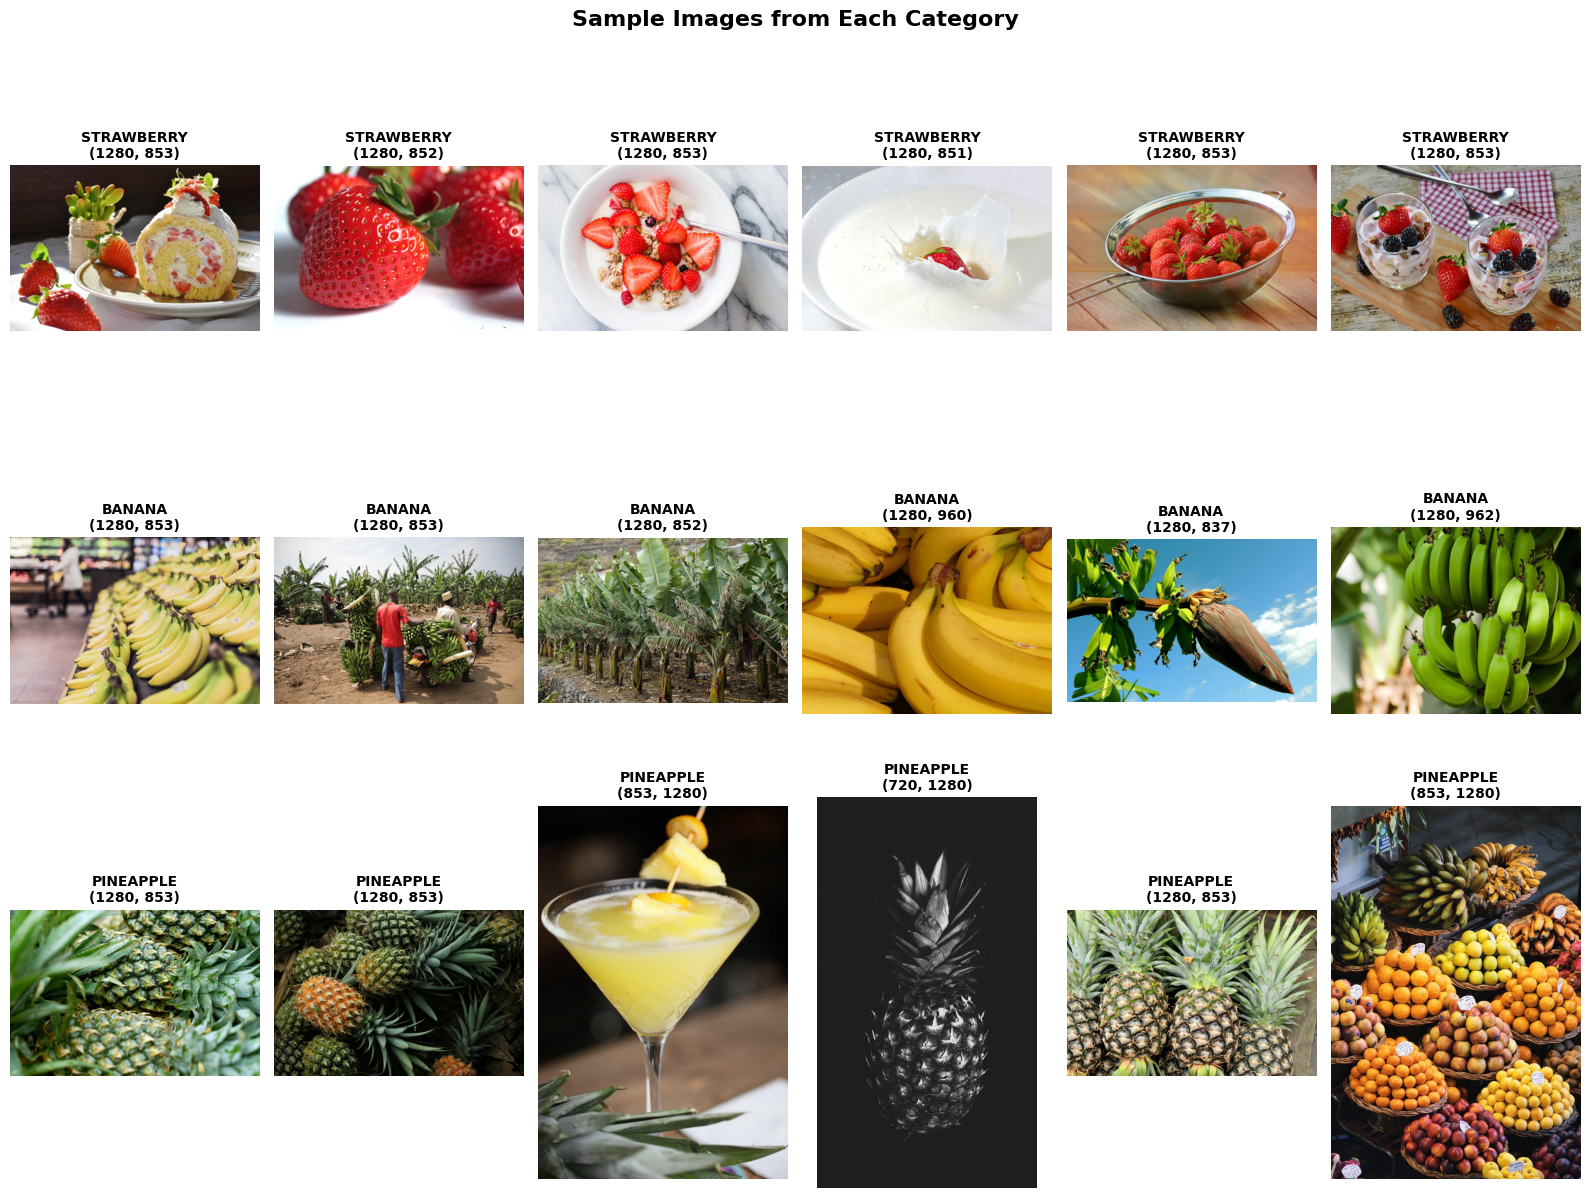

✓ Sample images loaded and displayed


In [31]:
# Visualize sample images from each category
num_samples = 6
fig, axes = plt.subplots(len(CATEGORIES), num_samples, figsize=(16, 4 * len(CATEGORIES)))

if len(CATEGORIES) == 1:
    axes = axes.reshape(1, -1)

for row, category in enumerate(CATEGORIES):
    sample_images = valid_images[category][:num_samples]

    for col, filepath in enumerate(sample_images):
        ax = axes[row, col]
        try:
            img = Image.open(filepath)
            ax.imshow(img)
            ax.set_title(f"{category.upper()}\n{img.size}", fontsize=10, fontweight='bold')
            ax.axis('off')
        except:
            ax.text(0.5, 0.5, 'Error loading image', ha='center', va='center')
            ax.axis('off')

plt.suptitle('Sample Images from Each Category', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Sample images loaded and displayed")

In [32]:
# Analyze image properties
image_sizes = defaultdict(list)
image_formats = defaultdict(int)

for category, images in valid_images.items():
    for filepath in images:
        try:
            img = Image.open(filepath)
            image_sizes[category].append(img.size)
            image_formats[img.format if img.format else 'unknown'] += 1
        except:
            pass

# Print statistics
print("\nIMAGE STATISTICS:")
print("="*60)
for category, sizes in image_sizes.items():
    widths = [s[0] for s in sizes]
    heights = [s[1] for s in sizes]
    print(f"\n{category.upper()}:")
    print(f"  Count: {len(sizes)} images")
    print(f"  Width: {np.mean(widths):.0f} ± {np.std(widths):.0f} px (min: {min(widths)}, max: {max(widths)})")
    print(f"  Height: {np.mean(heights):.0f} ± {np.std(heights):.0f} px (min: {min(heights)}, max: {max(heights)})")

print(f"\nImage Formats: {dict(image_formats)}")
print("="*60)


IMAGE STATISTICS:

STRAWBERRY:
  Count: 150 images
  Width: 1214 ± 147 px (min: 802, max: 1280)
  Height: 937 ± 182 px (min: 428, max: 1280)

BANANA:
  Count: 150 images
  Width: 1217 ± 145 px (min: 811, max: 1280)
  Height: 931 ± 189 px (min: 466, max: 1280)

PINEAPPLE:
  Count: 150 images
  Width: 1109 ± 213 px (min: 511, max: 1280)
  Height: 1043 ± 210 px (min: 719, max: 1280)

Image Formats: {'JPEG': 450}


---
## Part 3: Create Train/Validation/Test Split

In [33]:
import shutil

# Split ratio: 70% train, 15% validation, 15% test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

print("Organizing images into train/val/test splits...\n")

split_counts = {'train': {}, 'val': {}, 'test': {}}

for category in CATEGORIES:
    images = valid_images[category]
    random.shuffle(images)  # Randomize order

    n_total = len(images)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)

    # Split
    train_images = images[:n_train]
    val_images = images[n_train:n_train + n_val]
    test_images = images[n_train + n_val:]

    # Copy to respective directories
    for i, img_path in enumerate(train_images):
        dest = os.path.join(TRAIN_DIR, category, f"{category}_{i:03d}.jpg")
        shutil.copy2(img_path, dest)

    for i, img_path in enumerate(val_images):
        dest = os.path.join(VAL_DIR, category, f"{category}_{i:03d}.jpg")
        shutil.copy2(img_path, dest)

    for i, img_path in enumerate(test_images):
        dest = os.path.join(TEST_DIR, category, f"{category}_{i:03d}.jpg")
        shutil.copy2(img_path, dest)

    split_counts['train'][category] = len(train_images)
    split_counts['val'][category] = len(val_images)
    split_counts['test'][category] = len(test_images)

    print(f"{category.upper()}:")
    print(f"  Train: {len(train_images)} | Val: {len(val_images)} | Test: {len(test_images)}")

# Print summary
print("\n" + "="*60)
print("DATASET SPLIT SUMMARY:")
print("="*60)

for split in ['train', 'val', 'test']:
    total = sum(split_counts[split].values())
    print(f"{split.upper():10s}: {total:3d} images (70/15/15 ratio)")

print("="*60)

Organizing images into train/val/test splits...

STRAWBERRY:
  Train: 105 | Val: 22 | Test: 23
BANANA:
  Train: 105 | Val: 22 | Test: 23
PINEAPPLE:
  Train: 105 | Val: 22 | Test: 23

DATASET SPLIT SUMMARY:
TRAIN     : 315 images (70/15/15 ratio)
VAL       :  66 images (70/15/15 ratio)
TEST      :  69 images (70/15/15 ratio)


---
## Part 4: Data Loading and Preprocessing Pipeline

In [34]:
# Image parameters (standard for ImageNet pre-trained models)
IMG_SIZE = 224
BATCH_SIZE = 32

# Data augmentation for training (prevents overfitting)
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,      # Random rotation
    width_shift_range=0.2,  # Random horizontal shift
    height_shift_range=0.2, # Random vertical shift
    shear_range=0.2,        # Shearing
    zoom_range=0.2,         # Random zoom
    horizontal_flip=True,   # Random horizontal flip
    fill_mode='nearest'     # Fill mode for new pixels
)

# No augmentation for validation/test (just rescale)
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=42
)

# Get class labels
class_labels = train_generator.class_indices
class_names = {v: k for k, v in class_labels.items()}

num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class mapping: {class_names}")
print(f"\nTrain samples: {train_generator.samples}")
print(f"Val samples: {val_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Found 315 images belonging to 3 classes.
Found 66 images belonging to 3 classes.
Found 69 images belonging to 3 classes.
Number of classes: 3
Class mapping: {0: 'banana', 1: 'pineapple', 2: 'strawberry'}

Train samples: 315
Val samples: 66
Test samples: 69


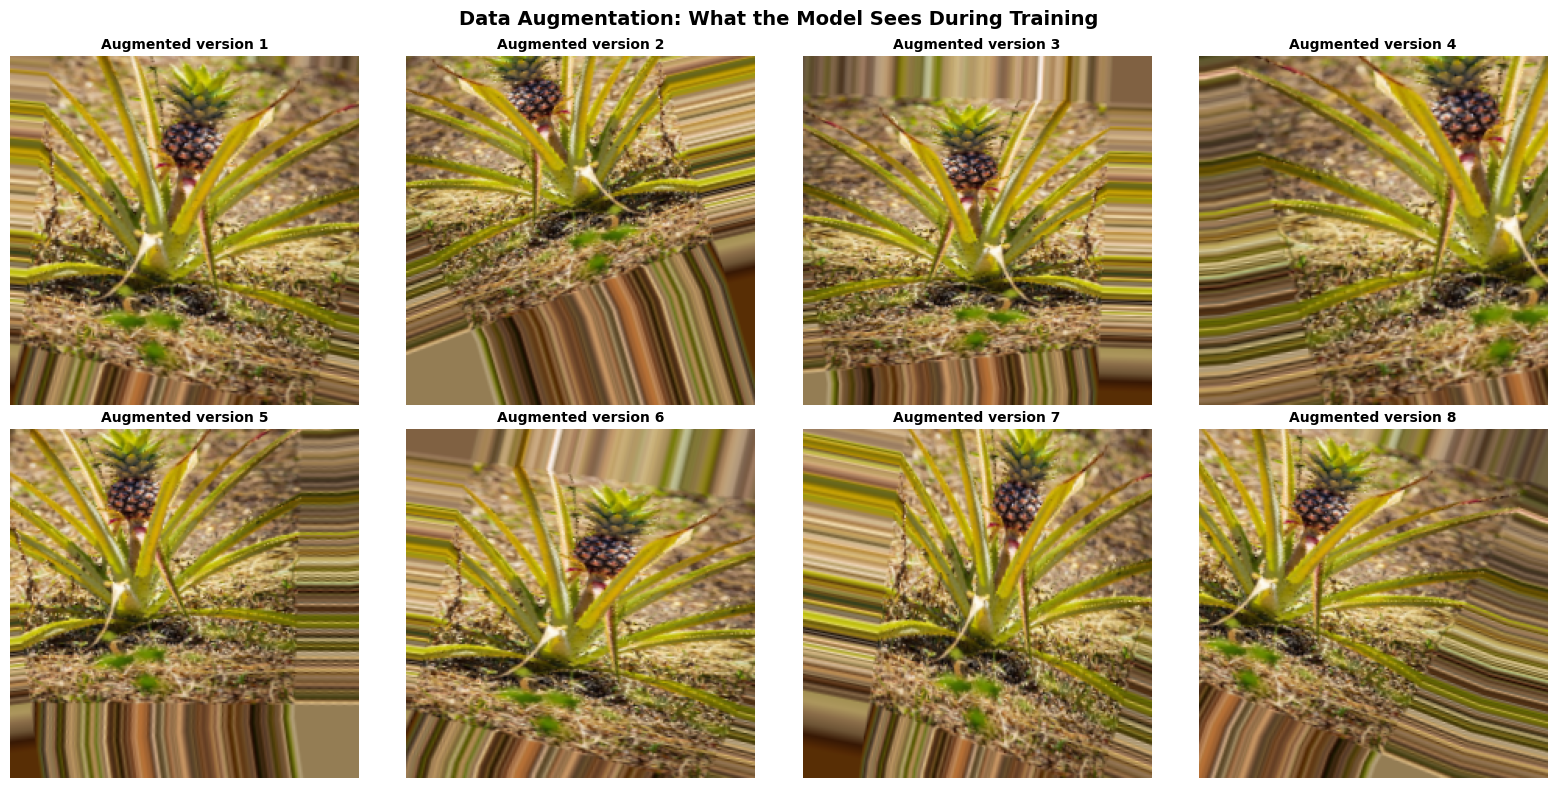

Data augmentation helps prevent overfitting by showing the model
different versions of the same image (rotated, zoomed, flipped, etc.)


In [35]:
# Visualize augmented images to show what the model sees during training
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

# Get a single image and apply augmentation multiple times
sample_batch = next(train_generator)
sample_image = sample_batch[0][0]  # Get first image from first batch

# Show original and augmented versions
for i in range(8):
    augmented = train_datagen.random_transform(sample_image)
    axes[i].imshow(augmented)
    axes[i].set_title(f"Augmented version {i+1}", fontsize=10, fontweight='bold')
    axes[i].axis('off')

plt.suptitle('Data Augmentation: What the Model Sees During Training',
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print("Data augmentation helps prevent overfitting by showing the model")
print("different versions of the same image (rotated, zoomed, flipped, etc.)")

---
## Part 5: Build Fine-Tuning Models

### Understanding Transfer Learning

1. **Load pre-trained model** with weights from ImageNet
2. **Freeze base layers** (don't train them)
3. **Add custom head** (new classification layers)
4. **Train only the head** (uses knowledge from base)


In [36]:
def build_transfer_model(model_name, num_classes, input_shape=(224, 224, 3)):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    elif model_name == 'MobileNetV2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    # Freeze the base model
    base_model.trainable = False

    # These are the only layers I'll train
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        base_model,

        # Global average pooling: reduce spatial dimensions
        layers.GlobalAveragePooling2D(),

        # Dense layers for learning decision boundary
        layers.Dense(256, activation='relu') ,  # Prevent overfitting
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),

        # Output layer: one neuron per class
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, base_model

# Test building a model
test_model, test_base = build_transfer_model('VGG16', num_classes)
print("✓ Model building function created")
print(f"\nTest model summary (VGG16):")
test_model.summary()

✓ Model building function created

Test model summary (VGG16):


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,299 (56.76 MB)

 Trainable params: 164,611 (643.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [37]:
# Show which layers are trainable
print("\n" + "="*70)
print("LAYER TRAINABILITY:")
print("="*70)

trainable_count = 0
non_trainable_count = 0

for layer in test_model.layers:
    if hasattr(layer, 'layers'):
        count = len(layer.layers)
        trainable = sum(1 for l in layer.layers if l.trainable)
        print(f"\n{layer.name}:")
        print(f"  Total layers: {count}")
        print(f"  Trainable layers: {trainable}")
        print(f"  Frozen layers: {count - trainable}")
        trainable_count += sum(p.numpy().size for l in layer.layers if l.trainable for p in l.trainable_weights)
        non_trainable_count += sum(p.numpy().size for l in layer.layers if not l.trainable for p in l.trainable_weights)
    else:
        if layer.trainable:
            trainable_count += sum(p.numpy().size for p in layer.trainable_weights)

print("\n" + "="*70)
print(f"Total trainable parameters: {trainable_count:,}")
print(f"Total frozen parameters: {non_trainable_count:,}")
print("="*70)


LAYER TRAINABILITY:

vgg16:
  Total layers: 19
  Trainable layers: 0
  Frozen layers: 19

Total trainable parameters: 164,611
Total frozen parameters: 0


---
## Part 6: Compile and Train Models

In [38]:
# Training configuration
EPOCHS = 15  # Can increase to 25-50 for better accuracy, but takes longer
LEARNING_RATE = 0.001

# Dictionary to store models and history
models_dict = {}
history_dict = {}

model_names = ['VGG16', 'ResNet50', 'MobileNetV2']

print(f"\nTraining configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Models to train: {model_names}\n")


Training configuration:
  Epochs: 15
  Learning rate: 0.001
  Batch size: 32
  Models to train: ['VGG16', 'ResNet50', 'MobileNetV2']



In [39]:
# Build and compile all three models
print("Building and compiling models...\n")

for model_name in model_names:
    print(f"{model_name}...")

    # Build model
    model, base_model = build_transfer_model(model_name, num_classes)
   
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Store model
    models_dict[model_name] = model

    print(f"   ✓ Compiled\n")

print("✓ All models compiled and ready for training!")

Building and compiling models...

VGG16...
   ✓ Compiled

ResNet50...
   ✓ Compiled

MobileNetV2...
   ✓ Compiled

✓ All models compiled and ready for training!


In [40]:
# Train all three models
print("\n" + "="*70)
print("TRAINING MODELS ON YOUR CUSTOM DATA")
print("="*70)

for model_name in model_names:
    print(f"Training {model_name}...")
    print(f"   Epochs: {EPOCHS} | Batches per epoch: {train_generator.samples // BATCH_SIZE}")

    # Train
    history = models_dict[model_name].fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        verbose=1  # Show progress
    )

    # Store history
    history_dict[model_name] = history

    # Get test accuracy
    test_loss, test_acc = models_dict[model_name].evaluate(test_generator, verbose=0)
    print(f"\n   ✓ {model_name} Training Complete!")
    print(f"   Test Accuracy: {test_acc:.4f}")

print("\n" + "="*70)
print("✓ ALL MODELS TRAINED!")
print("="*70)


TRAINING MODELS ON YOUR CUSTOM DATA
Training VGG16...
   Epochs: 15 | Batches per epoch: 9
Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 64s 6s/step - accuracy: 0.3143 - loss: 1.1623 - val_accuracy: 0.3485 - val_loss: 1.1086
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.4317 - loss: 1.0606 - val_accuracy: 0.5152 - val_loss: 1.0454
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 6s/step - accuracy: 0.4921 - loss: 0.9827 - val_accuracy: 0.5455 - val_loss: 0.9974
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 6s/step - accuracy: 0.5651 - loss: 0.9379 - val_accuracy: 0.6212 - val_loss: 0.9351
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.6190 - loss: 0.8588 - val_accuracy: 0.5758 - val_loss: 0.9438
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.6159 - loss: 0.8421 - val_accuracy: 0.5758 - val_loss: 0.8956
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step - accuracy: 0.6730 - loss: 0.8172 - val_accuracy: 0.5909 - val_loss: 0.8893
Epoch 8/15
10/10 ━━━━━━━━━

---
## Part 7: Visualize Training Progress

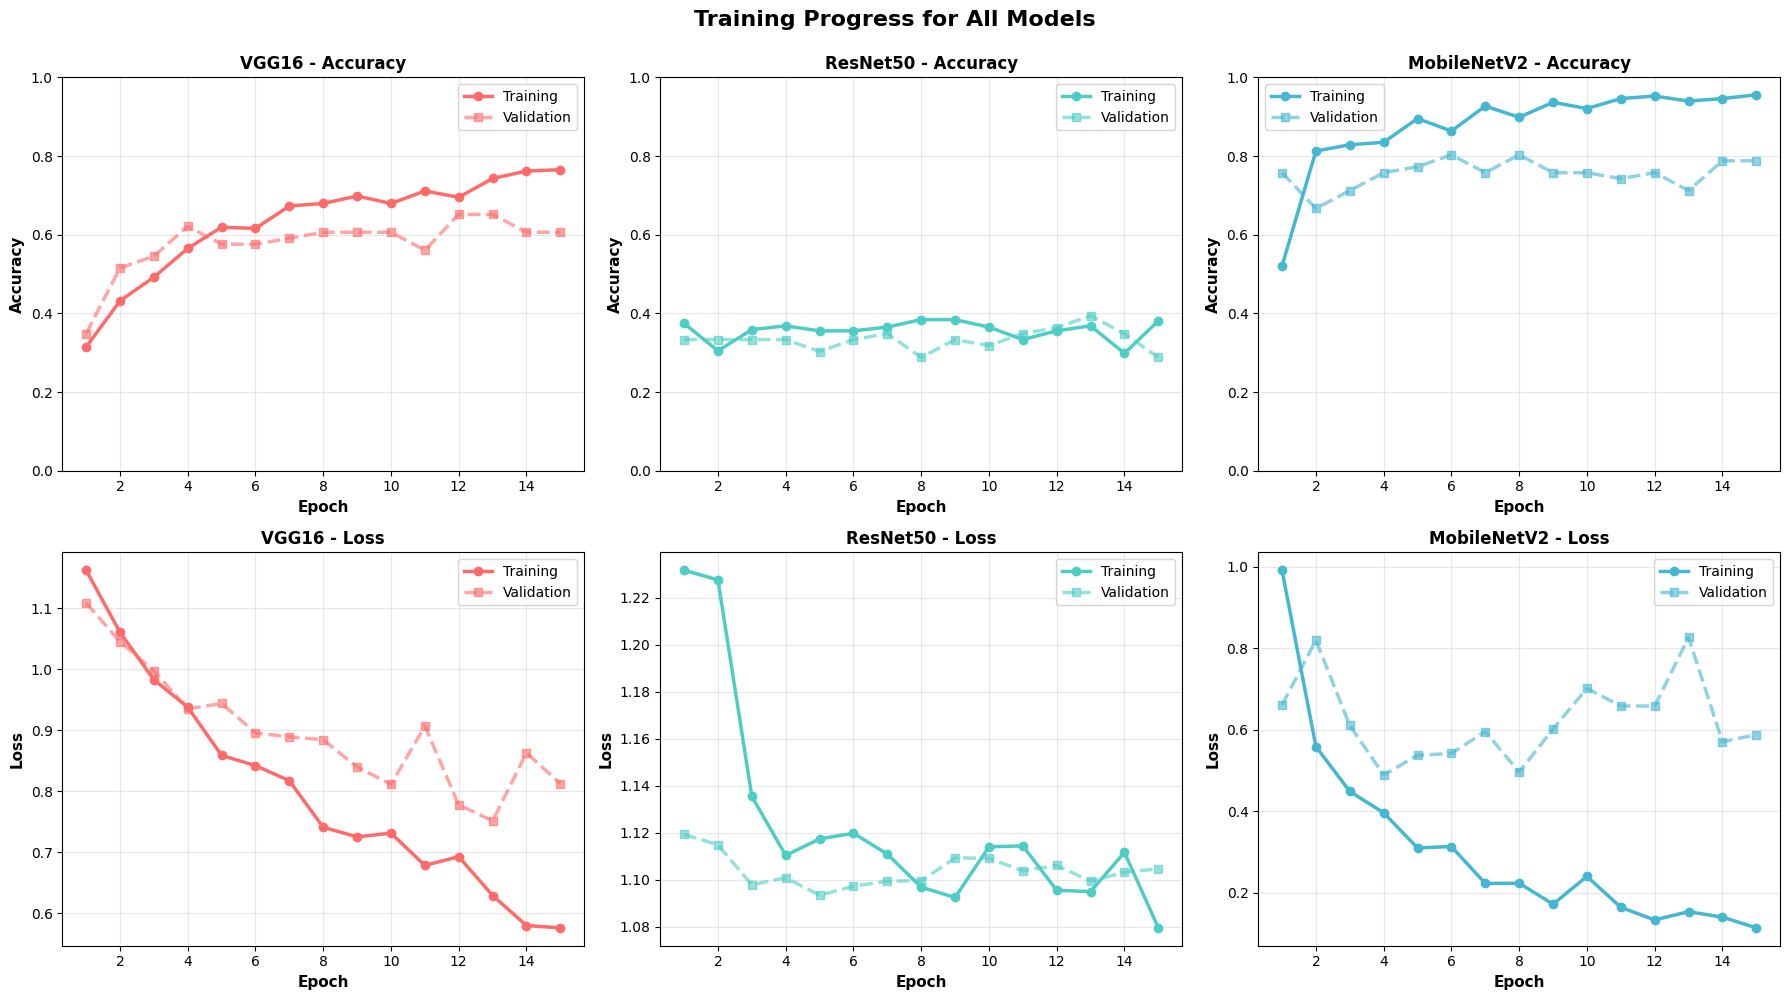

Interpretation:
  - If curves converge, model is learning well
  - If validation > training loss, model is overfitting
  - If training loss plateaus, try more epochs or adjust learning rate


In [41]:
# Plot training curves for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

colors = {'VGG16': '#FF6B6B', 'ResNet50': '#4ECDC4', 'MobileNetV2': '#45B7D1'}

for idx, model_name in enumerate(model_names):
    history = history_dict[model_name]

    # Accuracy plot
    ax = axes[0, idx]
    epochs_range = range(1, EPOCHS + 1)
    ax.plot(epochs_range, history.history['accuracy'], 'o-',
            label='Training', linewidth=2.5, markersize=6, color=colors[model_name])
    ax.plot(epochs_range, history.history['val_accuracy'], 's--',
            label='Validation', linewidth=2.5, markersize=6, color=colors[model_name], alpha=0.6)
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax.set_title(f"{model_name} - Accuracy", fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)
    ax.set_ylim([0, 1])

    # Loss plot
    ax = axes[1, idx]
    ax.plot(epochs_range, history.history['loss'], 'o-',
            label='Training', linewidth=2.5, markersize=6, color=colors[model_name])
    ax.plot(epochs_range, history.history['val_loss'], 's--',
            label='Validation', linewidth=2.5, markersize=6, color=colors[model_name], alpha=0.6)
    ax.set_xlabel('Epoch', fontsize=11, fontweight='bold')
    ax.set_ylabel('Loss', fontsize=11, fontweight='bold')
    ax.set_title(f"{model_name} - Loss", fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.3)

plt.suptitle('Training Progress for All Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("Interpretation:")
print("  - If curves converge, model is learning well")
print("  - If validation > training loss, model is overfitting")
print("  - If training loss plateaus, try more epochs or adjust learning rate")

---
## Part 8: Model Evaluation and Comparison

In [42]:
# Evaluate all models on test set
print("\n" + "="*70)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*70)

results = {}

for model_name in model_names:
    print(f"\n{model_name}:")

    # Evaluate
    test_loss, test_acc = models_dict[model_name].evaluate(test_generator, verbose=0)

    # Get final training accuracy (from last epoch)
    train_acc = history_dict[model_name].history['accuracy'][-1]
    val_acc = history_dict[model_name].history['val_accuracy'][-1]

    results[model_name] = {
        'train_acc': train_acc,
        'val_acc': val_acc,
        'test_acc': test_acc,
        'test_loss': test_loss,
        'model': models_dict[model_name]
    }

    print(f"  Training Accuracy:   {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Test Accuracy:       {test_acc:.4f}")
    print(f"  Test Loss:           {test_loss:.4f}")

print("\n" + "="*70)


FINAL MODEL EVALUATION ON TEST SET

VGG16:
  Training Accuracy:   0.7651
  Validation Accuracy: 0.6061
  Test Accuracy:       0.7971
  Test Loss:           0.5973

ResNet50:
  Training Accuracy:   0.3810
  Validation Accuracy: 0.2879
  Test Accuracy:       0.3913
  Test Loss:           1.0835

MobileNetV2:
  Training Accuracy:   0.9556
  Validation Accuracy: 0.7879
  Test Accuracy:       0.8986
  Test Loss:           0.3025



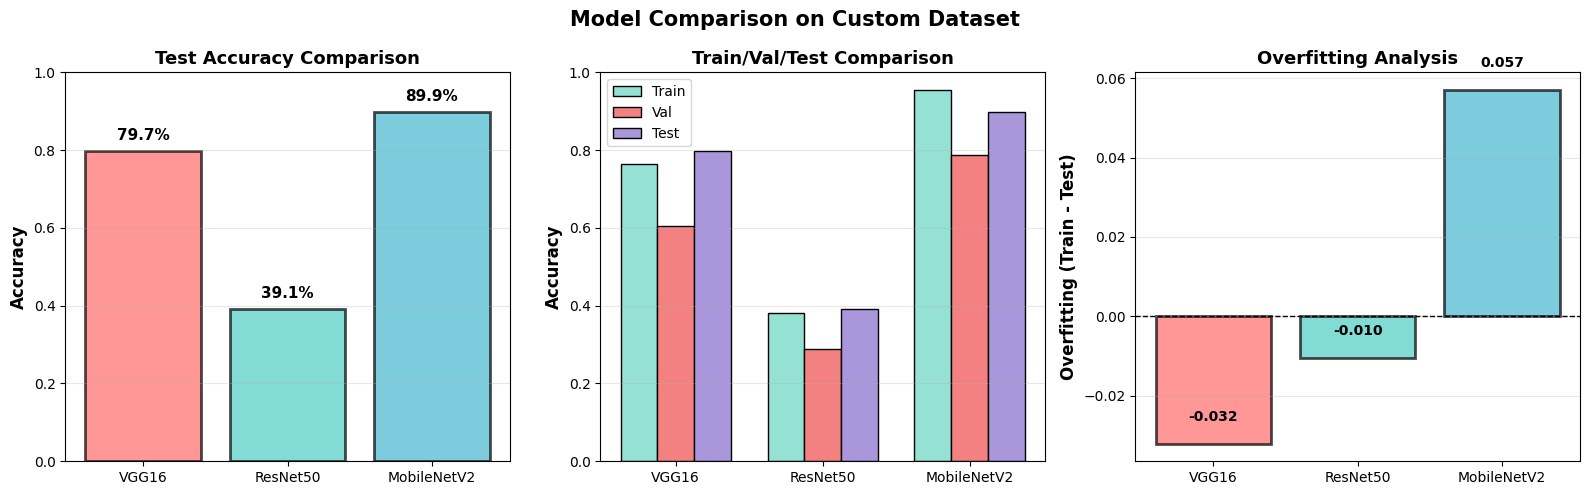

Analysis:
   - Higher test accuracy = better generalization
   - Lower overfitting = more reliable model


In [43]:
# Visualize results comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

model_names_list = list(results.keys())
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# 1. Test Accuracy Comparison
ax = axes[0]
test_accs = [results[m]['test_acc'] for m in model_names_list]
bars = ax.bar(model_names_list, test_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Test Accuracy Comparison', fontsize=13, fontweight='bold')
ax.set_ylim([0, 1])
ax.grid(alpha=0.3, axis='y')
for bar, val in zip(bars, test_accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
           f'{val:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# 2. Train vs Val vs Test
ax = axes[1]
x = np.arange(len(model_names_list))
width = 0.25

train_accs = [results[m]['train_acc'] for m in model_names_list]
val_accs = [results[m]['val_acc'] for m in model_names_list]
test_accs = [results[m]['test_acc'] for m in model_names_list]

ax.bar(x - width, train_accs, width, label='Train', color='#95E1D3', edgecolor='black')
ax.bar(x, val_accs, width, label='Val', color='#F38181', edgecolor='black')
ax.bar(x + width, test_accs, width, label='Test', color='#AA96DA', edgecolor='black')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Train/Val/Test Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names_list)
ax.legend(fontsize=10)
ax.set_ylim([0, 1])
ax.grid(alpha=0.3, axis='y')

# 3. Overfitting metric (train - test)
ax = axes[2]
overfitting = [results[m]['train_acc'] - results[m]['test_acc'] for m in model_names_list]
bars = ax.bar(model_names_list, overfitting, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Overfitting (Train - Test)', fontsize=12, fontweight='bold')
ax.set_title('Overfitting Analysis', fontsize=13, fontweight='bold')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax.grid(alpha=0.3, axis='y')
for bar, val in zip(bars, overfitting):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
           f'{val:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('Model Comparison on Custom Dataset', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("Analysis:")
print("   - Higher test accuracy = better generalization")
print("   - Lower overfitting = more reliable model")

---
## Part 9: Detailed Predictions and Confusion Matrices

In [44]:
# Generate predictions on test set
print("Generating predictions on test set...\n")

predictions_dict = {}

# Reset test generator
test_generator.reset()
test_images, test_labels = [], []

for images, labels in test_generator:
    test_images.append(images)
    test_labels.append(labels)
    if len(test_images) * BATCH_SIZE >= test_generator.samples:
        break

test_images = np.vstack(test_images)
test_labels = np.vstack(test_labels)

# Convert to class indices
true_labels = np.argmax(test_labels, axis=1)

# Get predictions for each model
for model_name in model_names:
    print(f"Predicting with {model_name}...")
    preds = models_dict[model_name].predict(test_images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)
    predictions_dict[model_name] = pred_labels

print("✓ Predictions complete")

Generating predictions on test set...

Predicting with VGG16...
Predicting with ResNet50...
Predicting with MobileNetV2...
✓ Predictions complete


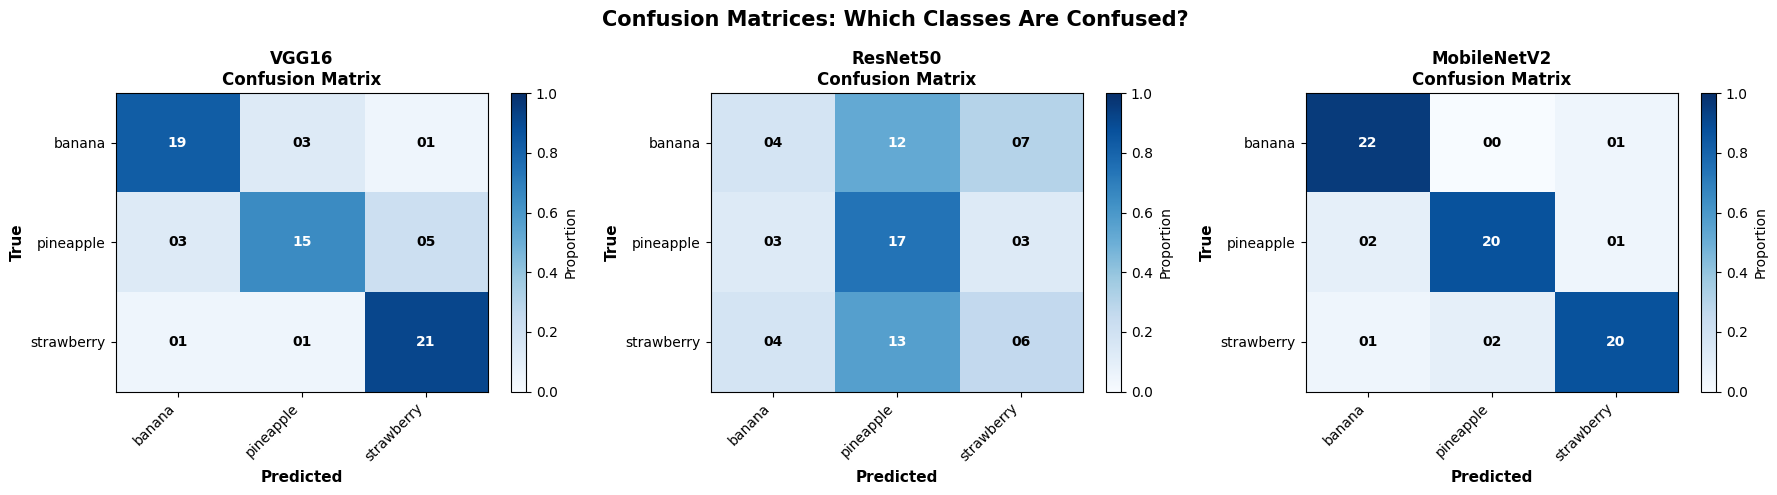

How to read these confusion matrices:
   - Diagonal = correct predictions (dark blue is good!)
   - Off-diagonal = mistakes
   - If a row is light, that class is often misclassified


In [45]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(model_names):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions_dict[model_name])

    # Normalize for better visualization
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot
    ax = axes[idx]
    im = ax.imshow(cm_normalized, cmap='Blues', aspect='auto', vmin=0, vmax=1)

    # Labels
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels([class_names[i] for i in range(num_classes)], rotation=45, ha='right')
    ax.set_yticklabels([class_names[i] for i in range(num_classes)])
    ax.set_xlabel('Predicted', fontsize=11, fontweight='bold')
    ax.set_ylabel('True', fontsize=11, fontweight='bold')
    ax.set_title(f"{model_name}\nConfusion Matrix", fontsize=12, fontweight='bold')

    # Add text annotations
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, f'{cm[i, j]}'.zfill(2),
                          ha="center", va="center", color="black" if cm_normalized[i, j] < 0.5 else "white",
                          fontweight='bold')

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Proportion', fontsize=10)

plt.suptitle('Confusion Matrices: Which Classes Are Confused?', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("How to read these confusion matrices:")
print("   - Diagonal = correct predictions (dark blue is good!)")
print("   - Off-diagonal = mistakes")
print("   - If a row is light, that class is often misclassified")

In [46]:
# Print detailed classification reports
print("\n" + "="*70)
print("DETAILED CLASSIFICATION REPORTS")
print("="*70)

for model_name in model_names:
    print(f"\n{model_name}:")
    print("-" * 70)
    print(classification_report(true_labels, predictions_dict[model_name],
                               target_names=[class_names[i] for i in range(num_classes)],
                               digits=4))

print("="*70)
print("Metrics explained:")
print("   - Precision: Of predicted positives, how many are actually correct?")
print("   - Recall: Of actual positives, how many did we find?")
print("   - F1-Score: Harmonic mean of precision and recall")


DETAILED CLASSIFICATION REPORTS

VGG16:
----------------------------------------------------------------------
              precision    recall  f1-score   support

      banana     0.8261    0.8261    0.8261        23
   pineapple     0.7895    0.6522    0.7143        23
  strawberry     0.7778    0.9130    0.8400        23

    accuracy                         0.7971        69
   macro avg     0.7978    0.7971    0.7935        69
weighted avg     0.7978    0.7971    0.7935        69


ResNet50:
----------------------------------------------------------------------
              precision    recall  f1-score   support

      banana     0.3636    0.1739    0.2353        23
   pineapple     0.4048    0.7391    0.5231        23
  strawberry     0.3750    0.2609    0.3077        23

    accuracy                         0.3913        69
   macro avg     0.3811    0.3913    0.3554        69
weighted avg     0.3811    0.3913    0.3554        69


MobileNetV2:
------------------------------

---
## Part 10: Visualize Model Predictions


Best Model: MobileNetV2 (Accuracy: 89.9%)



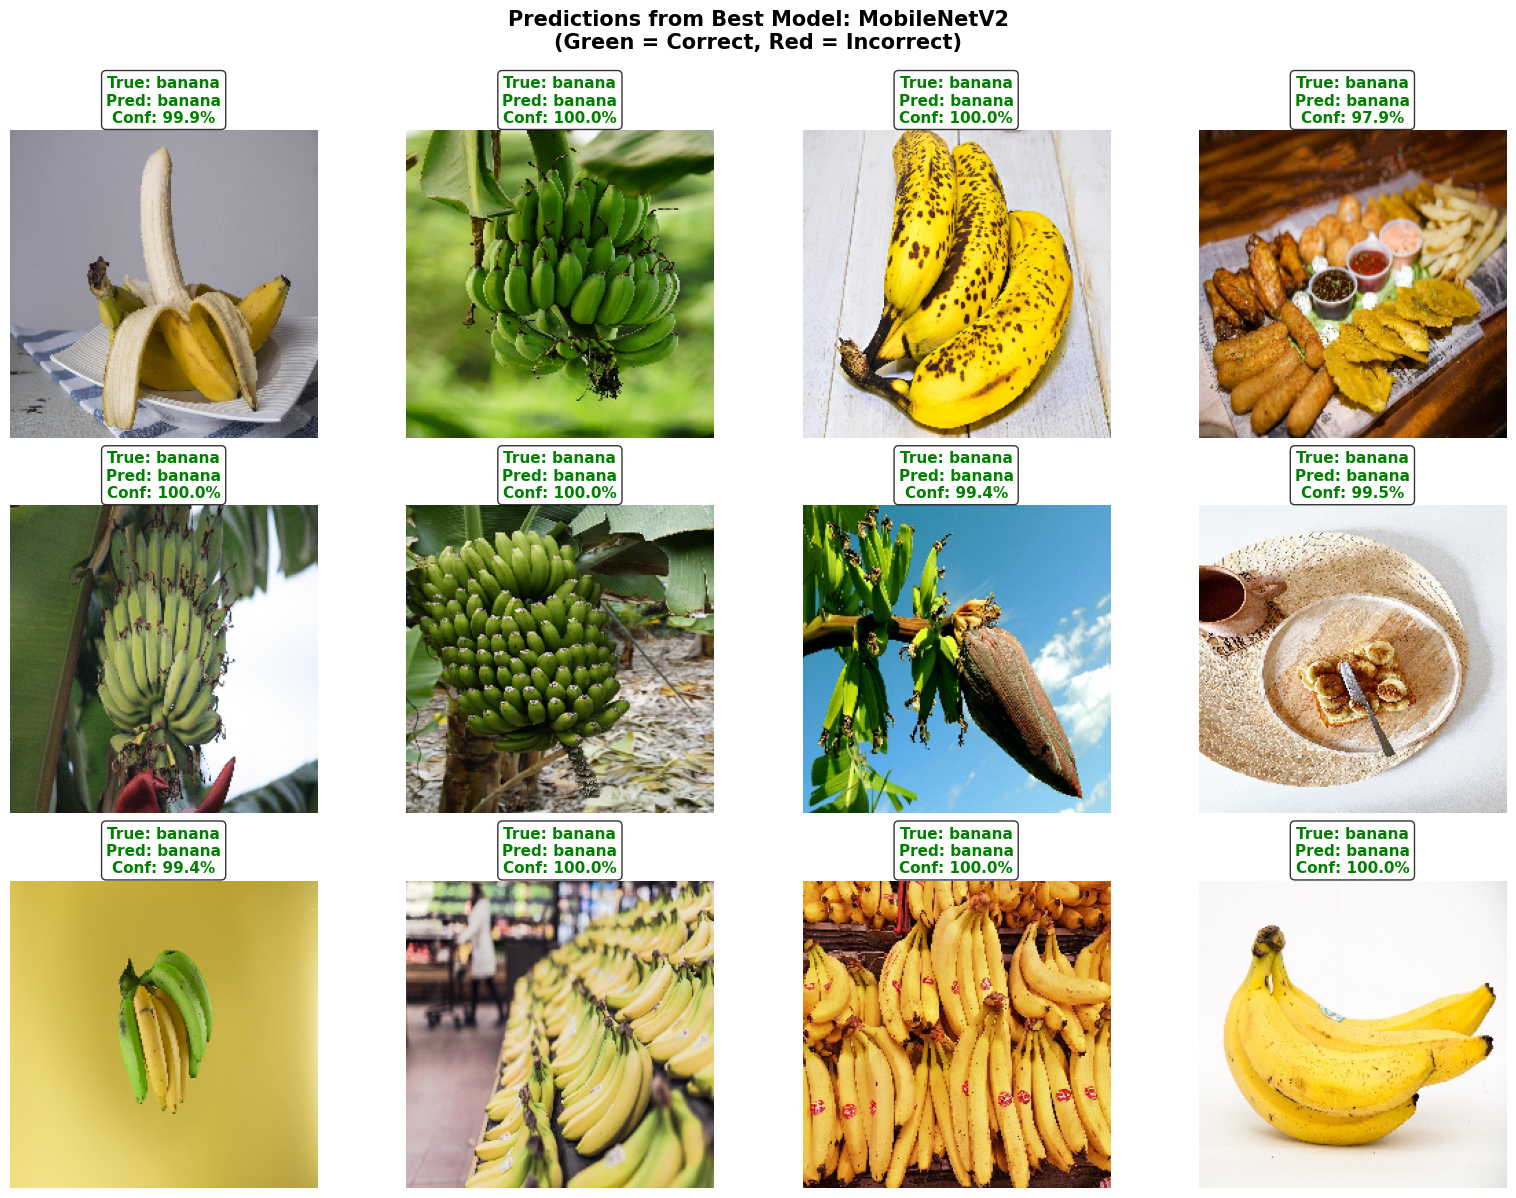

In [47]:
# Show example predictions from best model
best_model_name = max(results.keys(), key=lambda x: results[x]['test_acc'])
best_model = models_dict[best_model_name]

print(f"\nBest Model: {best_model_name} (Accuracy: {results[best_model_name]['test_acc']:.1%})\n")

# Get predictions with confidence scores
preds = best_model.predict(test_images, verbose=0)

# Plot example predictions
num_examples = 12
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

for i in range(num_examples):
    ax = axes[i]

    # Get image and prediction
    img = test_images[i]
    true_label = class_names[true_labels[i]]
    pred_label = class_names[np.argmax(preds[i])]
    confidence = np.max(preds[i])

    # Display image
    ax.imshow(img)
    ax.axis('off')

    # Color code: green if correct, red if wrong
    is_correct = true_label == pred_label
    color = 'green' if is_correct else 'red'

    title = f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1%}"
    ax.set_title(title, fontsize=11, fontweight='bold', color=color,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle(f'Predictions from Best Model: {best_model_name}\n(Green = Correct, Red = Incorrect)',
             fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

---
## Part 11: Save and Load Models (for Future Use)

In [48]:
# Save models for later use
models_dir = '/content/saved_models'
os.makedirs(models_dir, exist_ok=True)

print("Saving trained models...\n")

for model_name, model in models_dict.items():
    save_path = os.path.join(models_dir, f"{model_name}_fine_tuned.h5")
    model.save(save_path)
    print(f"  ✓ {model_name} saved to {save_path}")

print(f"\n✓ All models saved to {models_dir}")
print("\nYou can now download these models and use them for predictions!")

Saving trained models...

  ✓ VGG16 saved to /content/saved_models\VGG16_fine_tuned.h5


  ✓ ResNet50 saved to /content/saved_models\ResNet50_fine_tuned.h5
  ✓ MobileNetV2 saved to /content/saved_models\MobileNetV2_fine_tuned.h5

✓ All models saved to /content/saved_models

You can now download these models and use them for predictions!


In [49]:
# Example: Load a saved model
print("\nLoading saved model example:\n")

# Load a model
loaded_model = keras.models.load_model(os.path.join(models_dir, 'VGG16_fine_tuned.h5'))
print("✓ Model loaded successfully!")

# Make a prediction
test_img = test_images[0:1]  # Get first test image
prediction = loaded_model.predict(test_img, verbose=0)
predicted_class = class_names[np.argmax(prediction[0])]
confidence = np.max(prediction[0])

print(f"\nExample prediction:")
print(f"  Predicted class: {predicted_class}")
print(f"  Confidence: {confidence:.1%}")
print(f"\nYou can use this pattern to make predictions on new images!")


Loading saved model example:

✓ Model loaded successfully!

Example prediction:
  Predicted class: banana
  Confidence: 75.4%

You can use this pattern to make predictions on new images!
